# Gaze Data Visualization

This notebook visualizes the gaze tracking data extracted from the experiment.

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Gaze Data

In [3]:
def extract_gaze_features_from_trial(eye_data):
    """Extract gaze features from raw eye tracking data."""
    if not eye_data or len(eye_data) == 0:
        return None
    
    timestamps = np.array([s['time'] for s in eye_data])
    
    # Gaze 3D coordinates
    gaze_x_L = np.array([s.get('gazeL_X', np.nan) for s in eye_data])
    gaze_y_L = np.array([s.get('gazeL_Y', np.nan) for s in eye_data])
    gaze_x_R = np.array([s.get('gazeR_X', np.nan) for s in eye_data])
    gaze_y_R = np.array([s.get('gazeR_Y', np.nan) for s in eye_data])
    
    gaze_x = np.nanmean([gaze_x_L, gaze_x_R], axis=0)
    gaze_y = np.nanmean([gaze_y_L, gaze_y_R], axis=0)
    
    # Screen position (normalized)
    screen_x_L = np.array([s.get('pupilLSensorPosL_X', np.nan) for s in eye_data])
    screen_y_L = np.array([s.get('pupilLSensorPosL_Y', np.nan) for s in eye_data])
    screen_x_R = np.array([s.get('pupilLSensorPosR_X', np.nan) for s in eye_data])
    screen_y_R = np.array([s.get('pupilLSensorPosR_Y', np.nan) for s in eye_data])
    
    screen_x = np.nanmean([screen_x_L, screen_x_R], axis=0)
    screen_y = np.nanmean([screen_y_L, screen_y_R], axis=0)
    
    # Validity
    valid_L = np.array([s.get('validL', 0) for s in eye_data])
    valid_R = np.array([s.get('validR', 0) for s in eye_data])
    
    features = {}
    features['gaze_valid_pct'] = np.mean((valid_L > 0) & (valid_R > 0))
    
    # Filter valid samples
    valid_mask = (valid_L > 0) & (valid_R > 0)
    if valid_mask.sum() < 5:
        return None
    
    gaze_x_valid = gaze_x[valid_mask]
    gaze_y_valid = gaze_y[valid_mask]
    screen_x_valid = screen_x[valid_mask]
    screen_y_valid = screen_y[valid_mask]
    timestamps_valid = timestamps[valid_mask]
    
    # Statistics
    features['gaze_x_mean'] = np.nanmean(gaze_x_valid)
    features['gaze_x_std'] = np.nanstd(gaze_x_valid)
    features['gaze_y_mean'] = np.nanmean(gaze_y_valid)
    features['gaze_y_std'] = np.nanstd(gaze_y_valid)
    features['screen_x_mean'] = np.nanmean(screen_x_valid)
    features['screen_x_std'] = np.nanstd(screen_x_valid)
    features['screen_y_mean'] = np.nanmean(screen_y_valid)
    features['screen_y_std'] = np.nanstd(screen_y_valid)
    
    # Movement metrics
    dt = np.diff(timestamps_valid)
    dt[dt == 0] = 1e-6
    dx = np.diff(screen_x_valid)
    dy = np.diff(screen_y_valid)
    
    velocity = np.sqrt(dx**2 + dy**2) / dt
    features['gaze_velocity_mean'] = np.nanmean(velocity)
    features['gaze_velocity_std'] = np.nanstd(velocity)
    features['gaze_velocity_max'] = np.nanmax(velocity)
    
    acceleration = np.diff(velocity) / dt[:-1]
    features['gaze_acceleration_mean'] = np.nanmean(np.abs(acceleration))
    features['gaze_acceleration_std'] = np.nanstd(acceleration)
    
    # Fixations and saccades
    fixation_mask = velocity < 30
    saccade_mask = velocity > 100
    features['fixation_ratio'] = np.mean(fixation_mask)
    features['saccade_ratio'] = np.mean(saccade_mask)
    features['saccade_count'] = np.sum(np.diff(saccade_mask.astype(int)) == 1)
    
    # Dispersion
    features['gaze_dispersion_x'] = np.nanmax(screen_x_valid) - np.nanmin(screen_x_valid)
    features['gaze_dispersion_y'] = np.nanmax(screen_y_valid) - np.nanmin(screen_y_valid)
    
    # Path length
    features['gaze_path_length'] = np.sum(np.sqrt(dx**2 + dy**2))
    
    # Store raw data for visualization
    features['raw_data'] = {
        'timestamps': timestamps_valid,
        'screen_x': screen_x_valid,
        'screen_y': screen_y_valid,
        'gaze_x': gaze_x_valid,
        'gaze_y': gaze_y_valid,
        'velocity': velocity
    }
    
    return features

In [4]:
def map_subject_filename(json_filename):
    """Map raw JSON filename to subject ID."""
    import re
    match = re.search(r'(\d{4})_(\d{4})_LCT_DESKTOP-([A-Z0-9]+)', json_filename)
    if match:
        date1, date2, desktop_id = match.groups()
        return f"{date1}_{date2}_{desktop_id}"
    return None

def extract_gaze_data(raw_json_files):
    """Extract gaze features from all raw JSON files."""
    all_gaze_data = []
    
    for file_path in raw_json_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        subject_id = map_subject_filename(file_path.name)
        if not subject_id:
            continue
        
        trials = data.get('trials', [])
        
        for trial_idx, trial in enumerate(trials):
            eye_data = trial.get('eye', [])
            if not eye_data:
                continue
            
            gamble_details = trial.get('gamble details', {})
            trial_id = str(gamble_details.get('trial', trial_idx))
            
            gaze_features = extract_gaze_features_from_trial(eye_data)
            if gaze_features is None:
                continue
            
            gaze_features['subject_id'] = subject_id
            gaze_features['trial_id'] = f"{trial_id}_{subject_id}"
            all_gaze_data.append(gaze_features)
    
    return all_gaze_data

raw_json_dir = Path('../data/json')
raw_json_files = sorted(raw_json_dir.glob('*.json'))
print(f"Found {len(raw_json_files)} raw JSON files")

all_gaze_data = extract_gaze_data(raw_json_files)
print(f"Extracted {len(all_gaze_data)} trials with gaze data")

Found 10 raw JSON files
Extracted 1383 trials with gaze data


## 2. Feature Distribution Plots

In [5]:
# Create DataFrame without raw data
gaze_features_df = pd.DataFrame([{k: v for k, v in trial.items() if k != 'raw_data'} 
                                 for trial in all_gaze_data])

print(f"Gaze features: {len(gaze_features_df)} trials")
print(f"\nFeatures: {[c for c in gaze_features_df.columns if c not in ['subject_id', 'trial_id']]}")

Gaze features: 1383 trials

Features: ['gaze_valid_pct', 'gaze_x_mean', 'gaze_x_std', 'gaze_y_mean', 'gaze_y_std', 'screen_x_mean', 'screen_x_std', 'screen_y_mean', 'screen_y_std', 'gaze_velocity_mean', 'gaze_velocity_std', 'gaze_velocity_max', 'gaze_acceleration_mean', 'gaze_acceleration_std', 'fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']


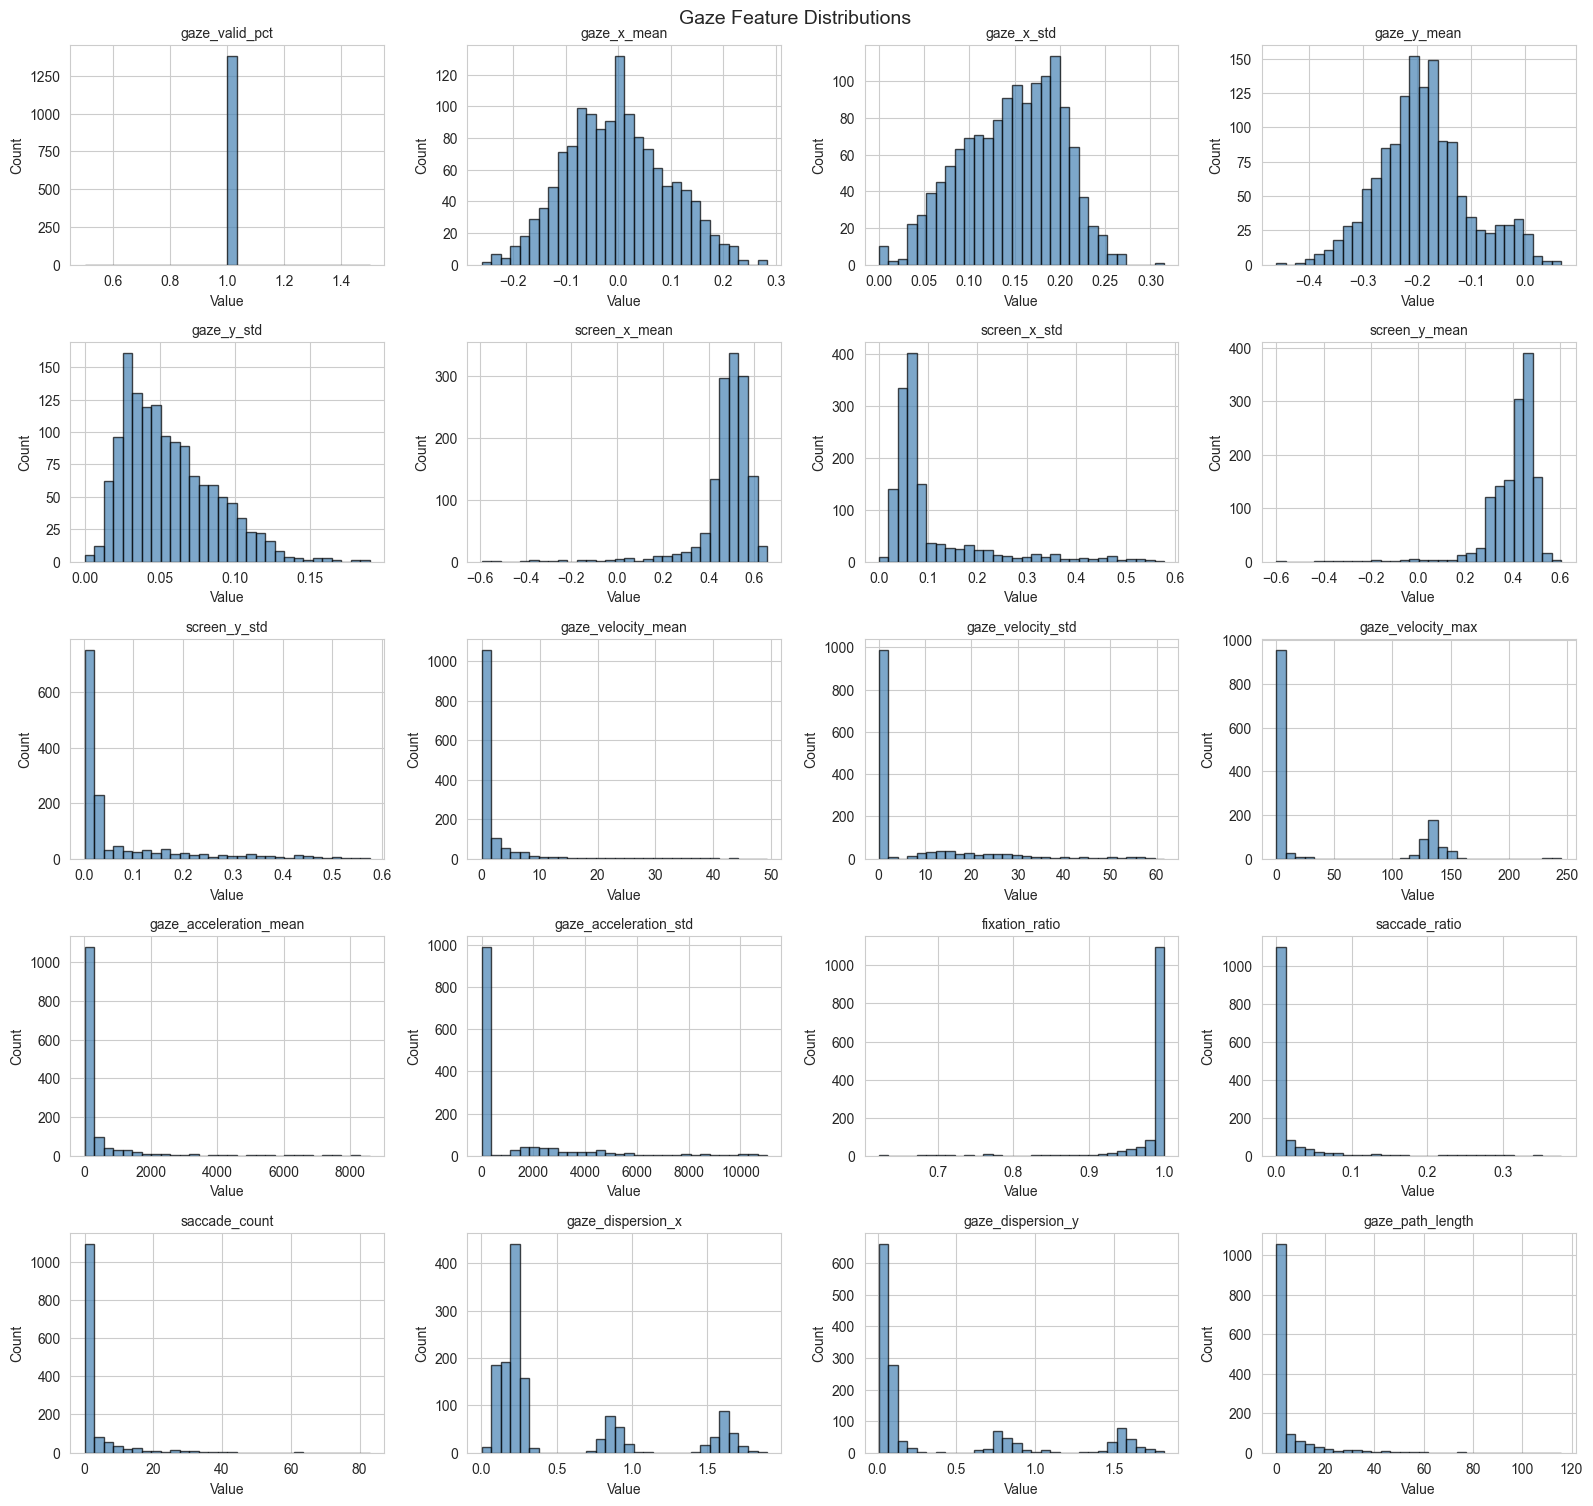

In [6]:
# Distribution of gaze metrics
numeric_cols = [c for c in gaze_features_df.columns 
                if c not in ['subject_id', 'trial_id'] and gaze_features_df[c].dtype in [np.float64, np.int64]]

n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    data = gaze_features_df[col].dropna()
    ax.hist(data, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

# Hide extra subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Gaze Feature Distributions', fontsize=14, y=1.001)
plt.show()

## 3. Gaze Position Heatmaps

In [7]:
# Aggregate all screen positions across trials
all_screen_x = []
all_screen_y = []

for trial in all_gaze_data:
    if 'raw_data' in trial:
        all_screen_x.extend(trial['raw_data']['screen_x'])
        all_screen_y.extend(trial['raw_data']['screen_y'])

all_screen_x = np.array(all_screen_x)
all_screen_y = np.array(all_screen_y)

print(f"Total gaze samples: {len(all_screen_x)}")

Total gaze samples: 404792


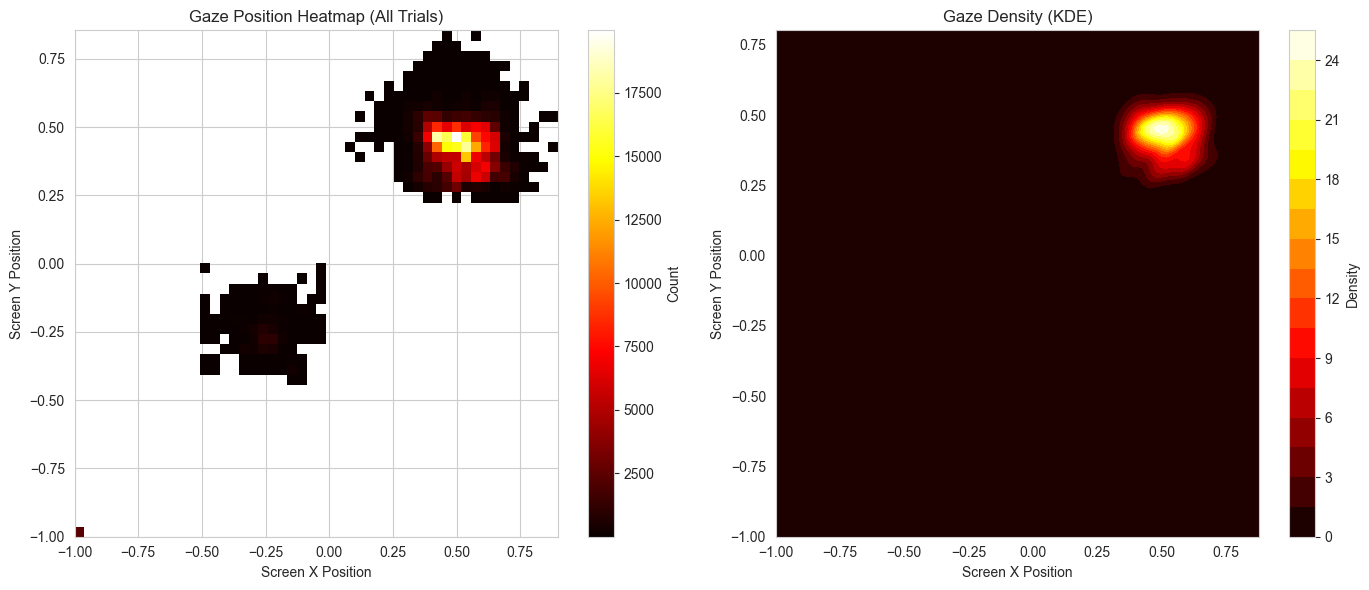

In [8]:
# Create heatmap of gaze positions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 2D histogram
ax = axes[0]
h = ax.hist2d(all_screen_x, all_screen_y, bins=50, cmap='hot', cmin=1)
plt.colorbar(h[3], ax=ax, label='Count')
ax.set_xlabel('Screen X Position')
ax.set_ylabel('Screen Y Position')
ax.set_title('Gaze Position Heatmap (All Trials)')

# Kernel density estimate
ax = axes[1]
try:
    from scipy.stats import gaussian_kde
    # Sample data if too large
    sample_size = min(10000, len(all_screen_x))
    sample_idx = np.random.choice(len(all_screen_x), sample_size, replace=False)
    x_sample = all_screen_x[sample_idx]
    y_sample = all_screen_y[sample_idx]
    
    # Create grid
    xi = np.linspace(x_sample.min(), x_sample.max(), 100)
    yi = np.linspace(y_sample.min(), y_sample.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Calculate density
    positions = np.vstack([Xi.ravel(), Yi.ravel()])
    values = np.vstack([x_sample, y_sample])
    kernel = gaussian_kde(values)
    Zi = np.reshape(kernel(positions).T, Xi.shape)
    
    im = ax.contourf(Xi, Yi, Zi, levels=20, cmap='hot')
    plt.colorbar(im, ax=ax, label='Density')
    ax.set_xlabel('Screen X Position')
    ax.set_ylabel('Screen Y Position')
    ax.set_title('Gaze Density (KDE)')
except Exception as e:
    ax.text(0.5, 0.5, f'KDE plot failed:\n{str(e)}', 
            ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

## 4. Gaze Trajectories (Sample Trials)

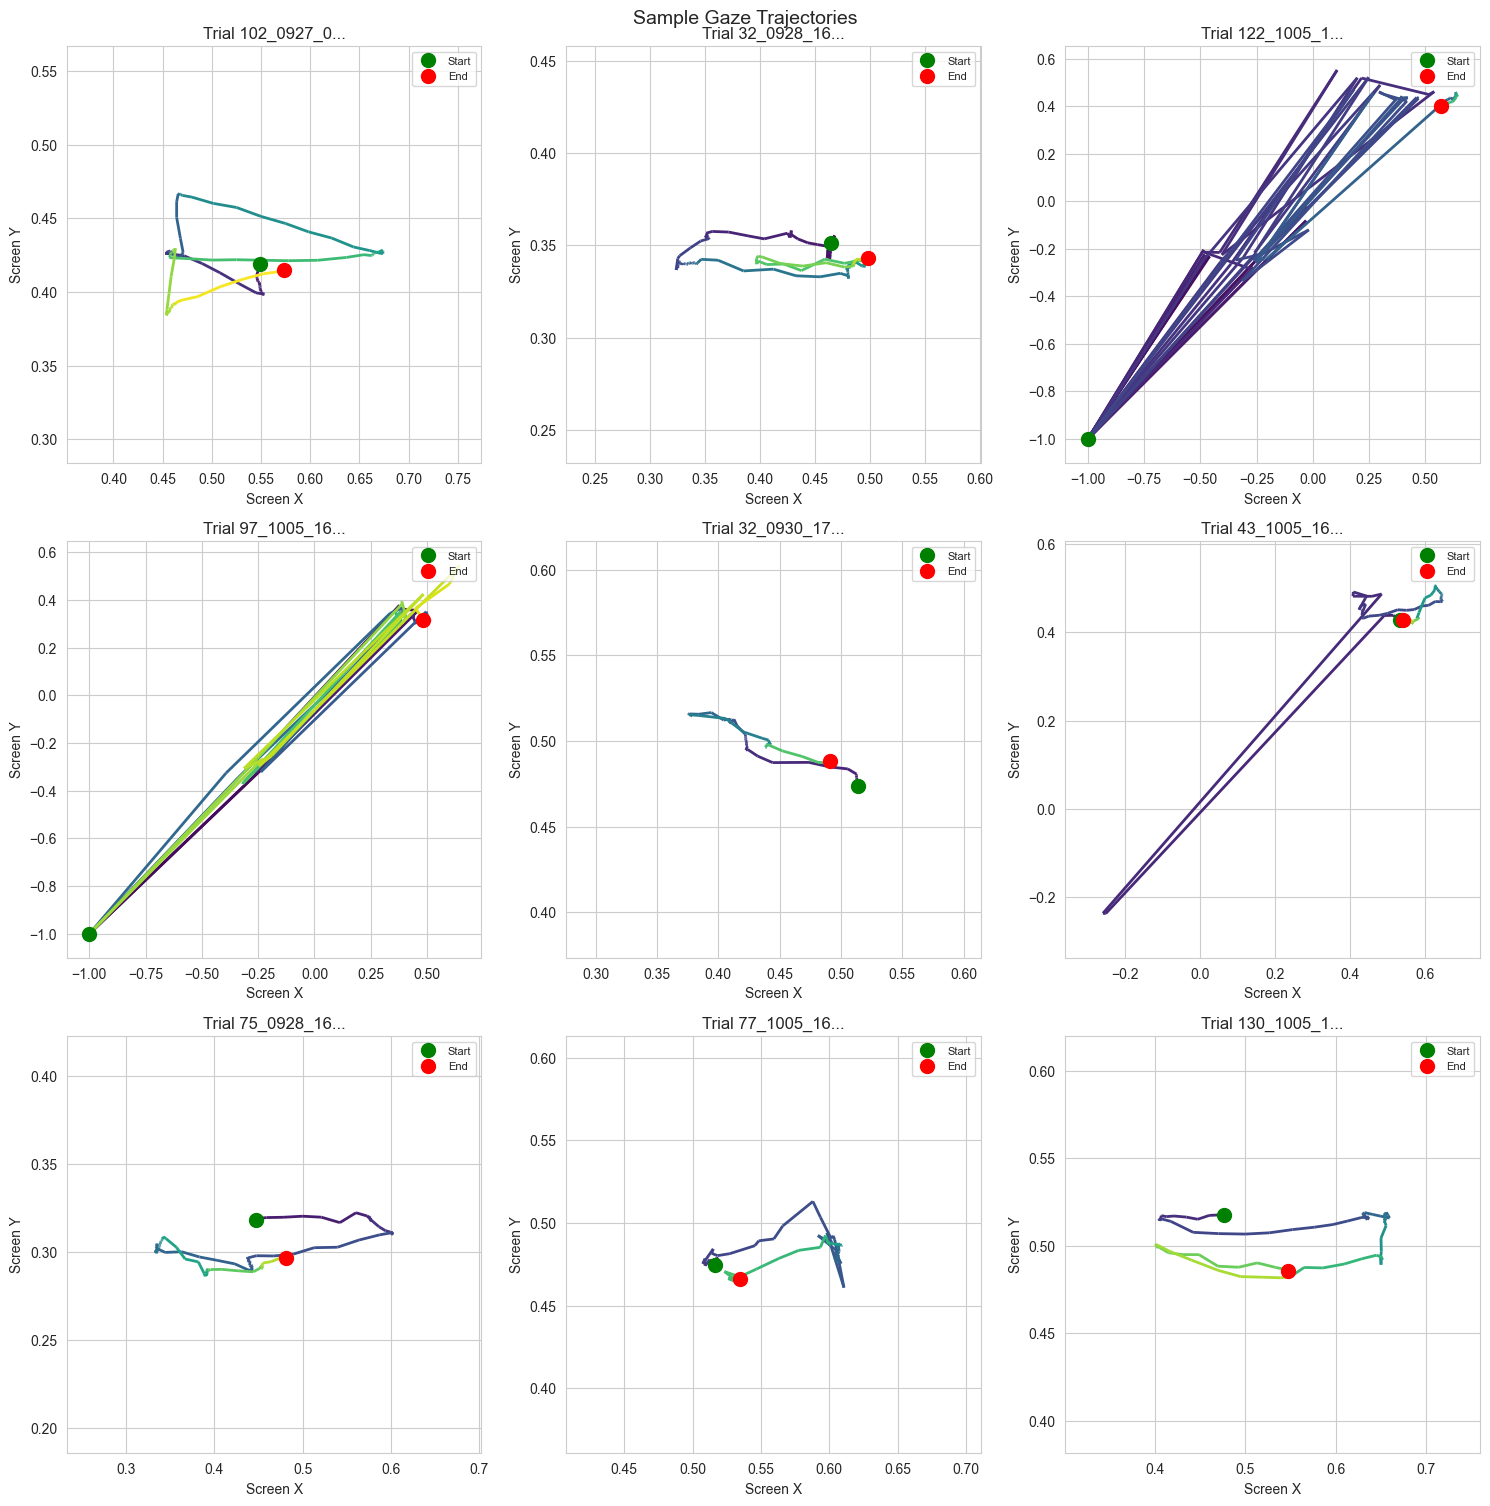

In [9]:
# Plot sample gaze trajectories
n_samples = min(9, len(all_gaze_data))
sample_indices = np.random.choice(len(all_gaze_data), n_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, trial_idx in enumerate(sample_indices):
    trial = all_gaze_data[trial_idx]
    if 'raw_data' not in trial:
        continue
    
    ax = axes[idx]
    raw = trial['raw_data']
    
    # Plot trajectory with color gradient
    points = np.array([raw['screen_x'], raw['screen_y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidth=2)
    lc.set_array(np.arange(len(segments)))
    ax.add_collection(lc)
    
    # Mark start and end
    ax.plot(raw['screen_x'][0], raw['screen_y'][0], 'go', markersize=10, label='Start')
    ax.plot(raw['screen_x'][-1], raw['screen_y'][-1], 'ro', markersize=10, label='End')
    
    ax.set_xlim([raw['screen_x'].min() - 0.1, raw['screen_x'].max() + 0.1])
    ax.set_ylim([raw['screen_y'].min() - 0.1, raw['screen_y'].max() + 0.1])
    ax.set_xlabel('Screen X')
    ax.set_ylabel('Screen Y')
    ax.set_title(f"Trial {trial['trial_id'][:10]}...")
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.suptitle('Sample Gaze Trajectories', fontsize=14, y=1.001)
plt.show()

## 5. Velocity and Movement Analysis

In [10]:
# Aggregate velocity data
all_velocities = []
for trial in all_gaze_data:
    if 'raw_data' in trial:
        all_velocities.extend(trial['raw_data']['velocity'])

all_velocities = np.array(all_velocities)
all_velocities = all_velocities[~np.isnan(all_velocities)]

print(f"Total velocity samples: {len(all_velocities)}")
print(f"Mean velocity: {np.mean(all_velocities):.2f}")
print(f"Median velocity: {np.median(all_velocities):.2f}")
print(f"Max velocity: {np.max(all_velocities):.2f}")

Total velocity samples: 403409
Mean velocity: 2.08
Median velocity: 0.06
Max velocity: 244.91


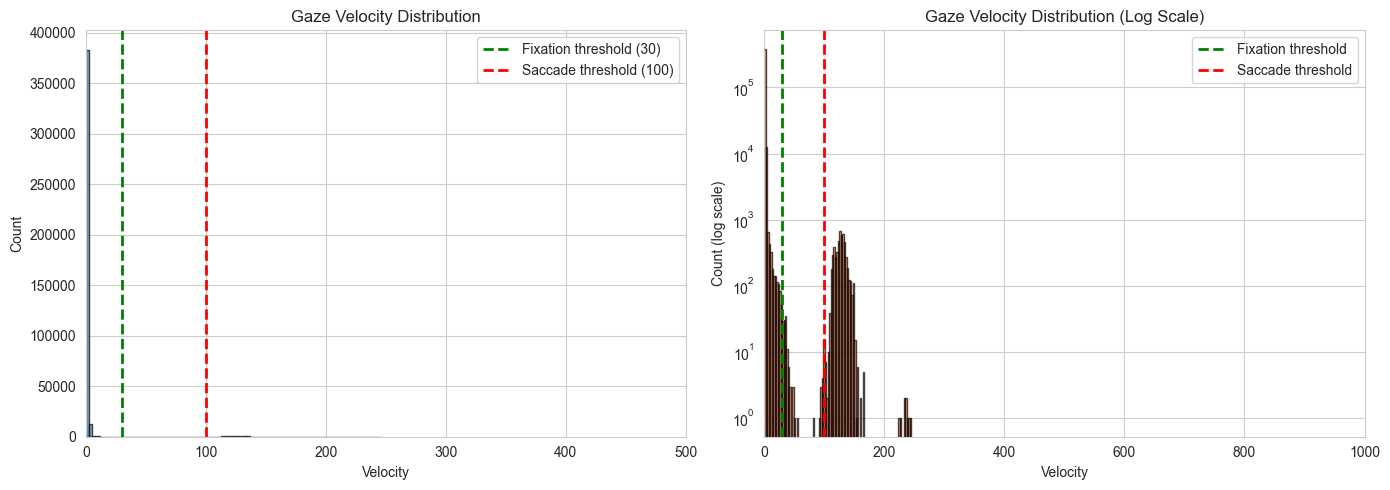

In [11]:
# Velocity distribution with fixation/saccade thresholds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(all_velocities, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(30, color='green', linestyle='--', linewidth=2, label='Fixation threshold (30)')
ax.axvline(100, color='red', linestyle='--', linewidth=2, label='Saccade threshold (100)')
ax.set_xlabel('Velocity')
ax.set_ylabel('Count')
ax.set_title('Gaze Velocity Distribution')
ax.set_xlim([0, 500])  # Zoom in on relevant range
ax.legend()

# Log scale
ax = axes[1]
ax.hist(all_velocities, bins=100, color='coral', alpha=0.7, edgecolor='black')
ax.axvline(30, color='green', linestyle='--', linewidth=2, label='Fixation threshold')
ax.axvline(100, color='red', linestyle='--', linewidth=2, label='Saccade threshold')
ax.set_xlabel('Velocity')
ax.set_ylabel('Count (log scale)')
ax.set_yscale('log')
ax.set_title('Gaze Velocity Distribution (Log Scale)')
ax.set_xlim([0, 1000])
ax.legend()

plt.tight_layout()
plt.show()

## 6. Temporal Patterns

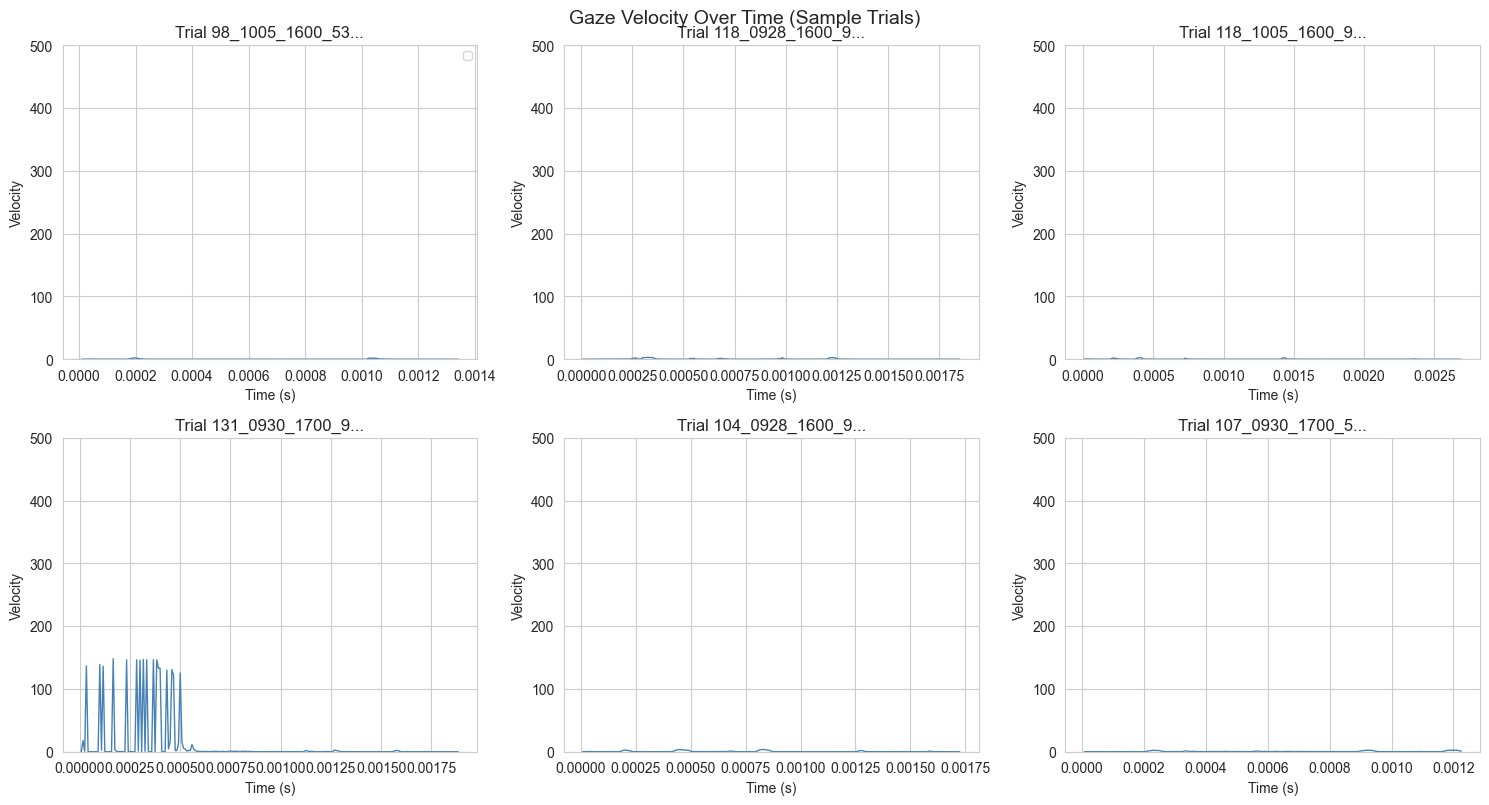

In [12]:
# Plot velocity over time for sample trials
n_samples = min(6, len(all_gaze_data))
sample_indices = np.random.choice(len(all_gaze_data), n_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, trial_idx in enumerate(sample_indices):
    trial = all_gaze_data[trial_idx]
    if 'raw_data' not in trial:
        continue
    
    ax = axes[idx]
    raw = trial['raw_data']
    
    # Normalize timestamps to start at 0
    time_norm = (raw['timestamps'] - raw['timestamps'][0]) / 1000  # Convert to seconds
    
    ax.plot(time_norm[1:], raw['velocity'], color='steelblue', linewidth=1)
    # ax.axhline(30, color='green', linestyle='--', alpha=0.5, label='Fixation')
    # ax.axhline(100, color='red', linestyle='--', alpha=0.5, label='Saccade')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Velocity')
    ax.set_title(f"Trial {trial['trial_id'][:15]}...")
    ax.set_ylim([0, 500])
    if idx == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Gaze Velocity Over Time (Sample Trials)', fontsize=14, y=1.001)
plt.show()

## 7. Summary Statistics by Subject

In [13]:
# Group by subject and compute statistics
subject_stats = gaze_features_df.groupby('subject_id').agg({
    'gaze_velocity_mean': ['mean', 'std'],
    'fixation_ratio': ['mean', 'std'],
    'saccade_count': ['mean', 'std'],
    'gaze_dispersion_x': ['mean', 'std'],
    'gaze_dispersion_y': ['mean', 'std'],
    'gaze_path_length': ['mean', 'std'],
    'trial_id': 'count'
}).round(3)

subject_stats.columns = ['_'.join(col).strip() for col in subject_stats.columns.values]
subject_stats = subject_stats.rename(columns={'trial_id_count': 'n_trials'})

print("\nGaze Statistics by Subject:")
subject_stats


Gaze Statistics by Subject:


,gaze_velocity_mean_mean,gaze_velocity_mean_std,fixation_ratio_mean,fixation_ratio_std,saccade_count_mean,saccade_count_std,gaze_dispersion_x_mean,gaze_dispersion_x_std,gaze_dispersion_y_mean,gaze_dispersion_y_std,gaze_path_length_mean,gaze_path_length_std,n_trials
subject_id,,,,,,,,,,,,,
0927_0930_U9TEJGM,0.687,1.183,0.997,0.008,0.860,2.557,0.343,0.285,0.242,0.361,2.060,3.504,179
0928_1600_539136F,2.520,4.372,0.984,0.033,4.045,9.140,0.591,0.519,0.462,0.478,6.394,12.674,134
0928_1600_9M4VCHG,0.644,1.701,0.997,0.013,0.674,3.263,0.325,0.334,0.152,0.322,1.754,4.663,138
0928_1600_U9TEJGM,2.788,3.141,0.983,0.024,4.450,6.748,0.830,0.611,0.797,0.678,8.054,9.911,131
0930_1700_539136F,0.636,1.322,0.997,0.010,0.636,2.435,0.237,0.201,0.096,0.209,1.199,2.815,132
0930_1700_9M4VCHG,0.899,2.877,0.995,0.020,0.956,4.339,0.323,0.399,0.189,0.431,2.123,6.341,136
0930_1700_U9TEJGM,2.703,3.930,0.982,0.030,3.933,6.627,0.839,0.668,0.720,0.718,7.744,11.252,135
1005_1600_539136F,0.874,1.652,0.995,0.013,0.917,2.538,0.322,0.476,0.247,0.481,2.069,4.552,132
1005_1600_9M4VCHG,0.704,1.877,0.997,0.015,0.677,3.037,0.322,0.309,0.174,0.322,1.743,4.942,133


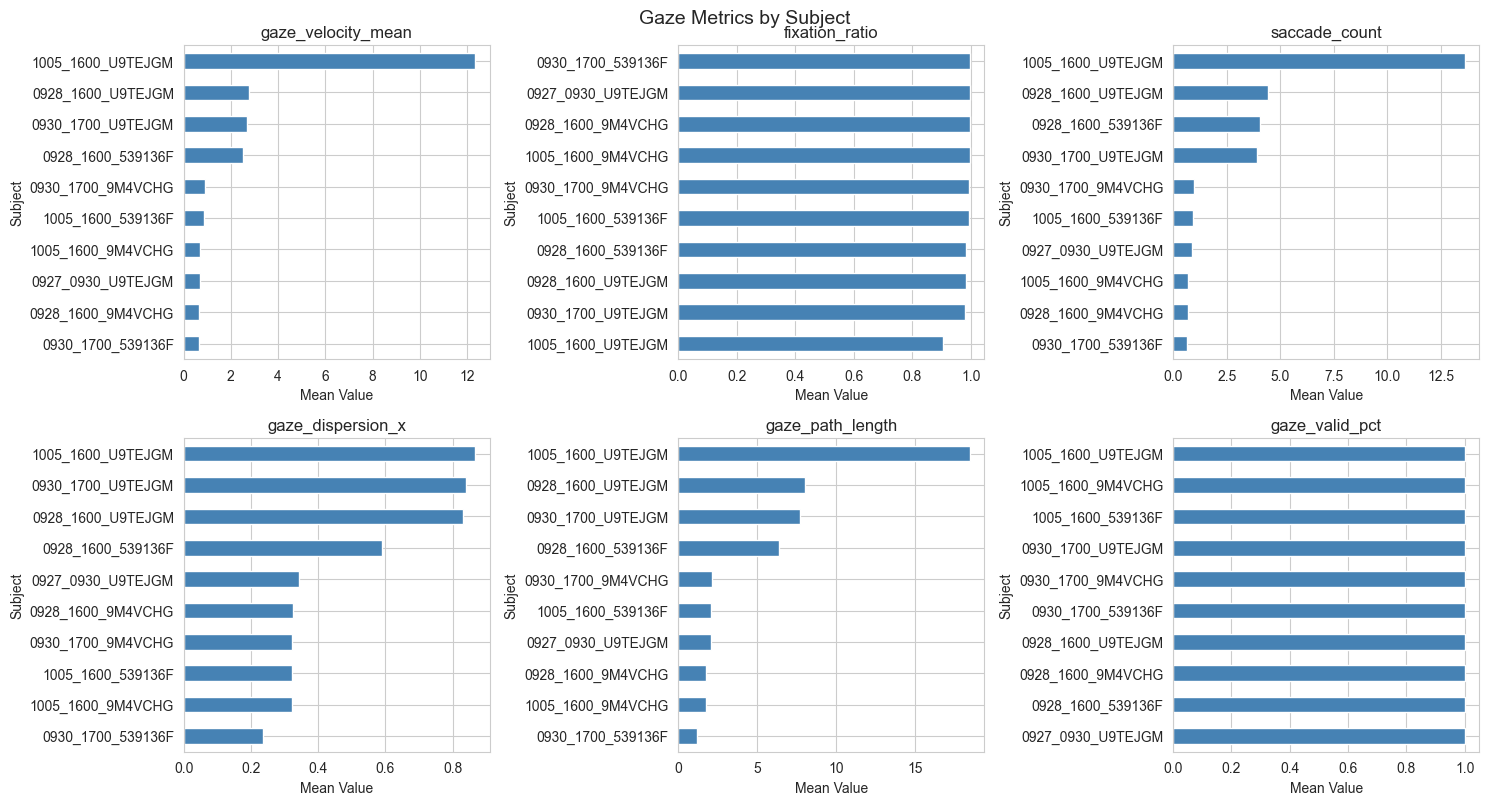

In [14]:
# Visualize subject-level differences
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

metrics = ['gaze_velocity_mean', 'fixation_ratio', 'saccade_count', 
           'gaze_dispersion_x', 'gaze_path_length', 'gaze_valid_pct']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subject_data = gaze_features_df.groupby('subject_id')[metric].mean().sort_values()
    subject_data.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_xlabel('Mean Value')
    ax.set_ylabel('Subject')
    ax.set_title(metric)

plt.tight_layout()
plt.suptitle('Gaze Metrics by Subject', fontsize=14, y=1.001)
plt.show()